In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

# Load the dataset
data = pd.read_csv('../data_with_state.csv')

# Convert the 'time' column to datetime and sort the data by time
data['time'] = pd.to_datetime(data['time'], format='%d-%m-%Y')
data = data.sort_values('time')

# Select features (latitude, longitude, and other variables) and target
features = ['lat', 'lon', 'week_no']
target = 'gws_inst'

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])


In [4]:

# Function to create sequences for the spatio-temporal model
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length, :-1])  # Features (excluding target)
        ys.append(data[i+seq_length, -1])     # Target (groundwater storage)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60  # Length of the sequence to capture temporal patterns
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the Spatio-Temporal CNN-LSTM model
model = Sequential()

# Spatial Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

# Another Convolutional Layer for deeper spatial feature extraction
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# # Flatten the output of the convolutional layers
# model.add(Flatten())

# Add LSTM layer to capture temporal dependencies
model.add(LSTM(100, activation='relu', return_sequences=False))

# Output Layer (for regression)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),callbacks=[early_stopping, reduce_lr])


Epoch 1/10
4272/4272 ━━━━━━━━━━━━━━━━━━━━ 112s 21ms/step - loss: 0.0720 - val_loss: 0.0459 - learning_rate: 0.0010
Epoch 2/10
4272/4272 ━━━━━━━━━━━━━━━━━━━━ 95s 22ms/step - loss: 0.0451 - val_loss: 0.0383 - learning_rate: 0.0010
Epoch 3/10
4272/4272 ━━━━━━━━━━━━━━━━━━━━ 153s 25ms/step - loss: 0.0376 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 4/10
4272/4272 ━━━━━━━━━━━━━━━━━━━━ 155s 28ms/step - loss: 0.0331 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 5/10
4272/4272 ━━━━━━━━━━━━━━━━━━━━ 90s 21ms/step - loss: 0.0294 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 6/10
4272/4272 ━━━━━━━━━━━━━━━━━━━━ 141s 21ms/step - loss: 0.0269 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 7/10
4272/4272 ━━━━━━━━━━━━━━━━━━━━ 92s 22ms/step - loss: 0.0248 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 8/10
4272/4272 ━━━━━━━━━━━━━━━━━━━━ 74s 17ms/step - loss: 0.0232 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 9/10
4272/4272 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - loss: 0.0218 - val_loss: 0

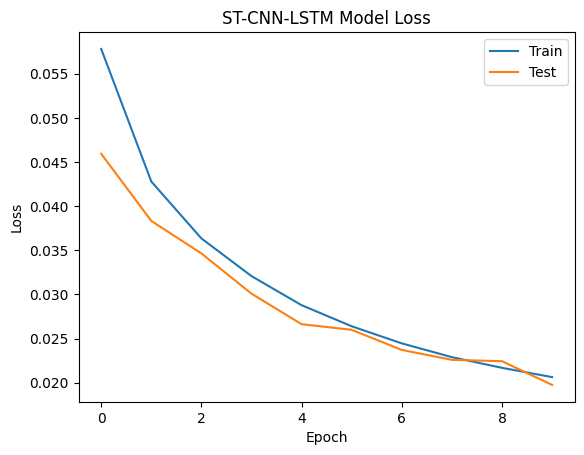

In [8]:

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ST-CNN-LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [9]:

# Make predictions on the test set
predictions = model.predict(X_test)


2136/2136 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step


In [10]:

# Rescale the predictions back to the original scale
y_test_rescaled = scaler.inverse_transform(np.concatenate([X_test[:, -1], y_test.reshape(-1,1)], axis=1))[:, -1]
predictions_rescaled = scaler.inverse_transform(np.concatenate([X_test[:, -1], predictions], axis=1))[:, -1]


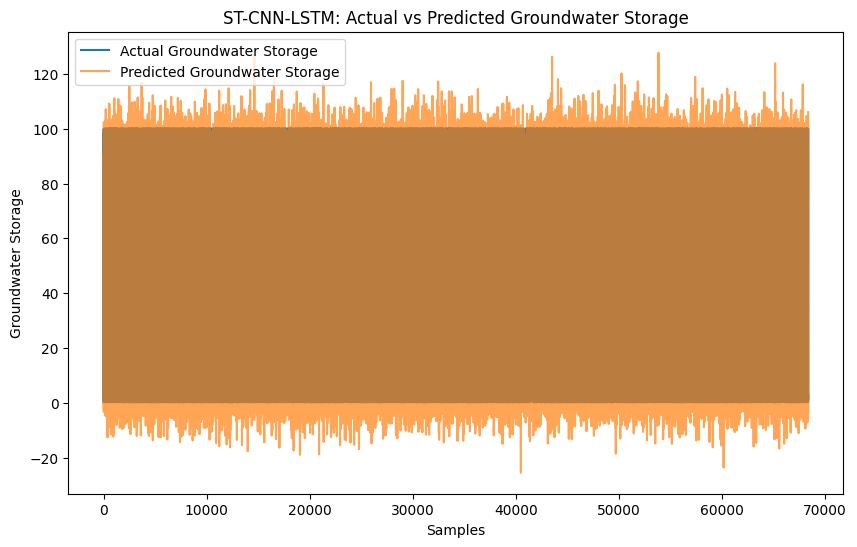

In [11]:

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Groundwater Storage')
plt.plot(predictions_rescaled, label='Predicted Groundwater Storage', alpha=0.7)
plt.title('ST-CNN-LSTM: Actual vs Predicted Groundwater Storage')
plt.xlabel('Samples')
plt.ylabel('Groundwater Storage')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 9.672309337155271
Mean Squared Error (MSE): 196.57642651259386
Root Mean Squared Error (RMSE): 14.020571547287002


In [13]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_rescaled, predictions_rescaled)
print("R² Score:", r2)

R² Score: 0.8541067726176284


In [14]:
# Number of samples
n = len(y_test_rescaled)

p=1

# Calculate Adjusted R²
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
adjusted_r2

0.8541046380529391